#Libs and utils

In [2]:
# %cd /content/drive/MyDrive/Dataset/DS105/Project/Codes/utils/
%cd ../utils/
import deterioration as imp

e:\projects\data_visualization\gan_imputation\utils


In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout, Input, LSTM, GRU, Multiply, Lambda, RNN, Bidirectional
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from keras.layers import *
import matplotlib.pyplot as plt  
import os
from keras.optimizers import Adam
import tqdm 
from keras import backend as K
from keras.utils import plot_model
from IPython.display import clear_output
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# Functions

In [ ]:
def adam_optimizer(alpha):
  return Adam(lr=alpha)

def create_generator(adam, timesteps, features):
  #-------------------------------------------------------------
  #units là số lượng phần tử trong sequence (timestep),
  input1 = Input((timesteps, features,))   #Đầu vào 1 là ma trận bị missing value
  mask = Input((timesteps, features,))  #Đầu vào thứ 2 là ma trận mask
  gru = Bidirectional(GRU(units = features, return_sequences=True))(input1)   
  gru1 = GRU(units = features, return_sequences=True)(gru)  #GRU nối với input1 để tạo ra ma trận mới, qua sigmoid nên sẽ nằm trong (0,1)
  gru2 = GRU(units = features, return_sequences=True, activation = "sigmoid")(gru1)
  lambda_ouput = Lambda(lambda x: (x * range_matrix) + min_matrix)(gru2) #Cái này để scale (0,1) thành trong (min,max) nè
  filled = Multiply()([lambda_ouput, mask]) #Nhân ma trận đã được điền khuyết bởi GRU (LSTM, RNN) với ma trận mask (ma trận này chỉ tồn tại giá trị được điền khuyết)
  final = Add()([input1, filled])  #Cuối cùng cộng ma trận ban đầu (input1) với ma trận chỉ tồn tại giá trị được điền khuyết (filled), nhằm tạo ra ma trận đã được điền khuyết

  model = Model(inputs = [input1,mask], outputs = final)
  #-------------------------------------------------------------
  # input1 = Input((timesteps, features,))   #Đầu vào 1 là ma trận bị missing value
  # mask = Input((timesteps, features,))  #Đầu vào thứ 2 là ma trận mask
  # gru = LSTM(units = features, return_sequences=True)(input1)   
  # # gru1 = GRU(units = features, return_sequences=True)(gru)  #GRU nối với input1 để tạo ra ma trận mới, qua sigmoid nên sẽ nằm trong (0,1)
  # # gru2 = GRU(units = features, return_sequences=True, activation = "sigmoid")(gru1)
  # # lambda_ouput = Lambda(lambda x: (x * range_matrix) + min_matrix)(gru2) #Cái này để scale (0,1) thành trong (min,max) nè
  # # filled = Multiply()([lambda_ouput, mask]) #Nhân ma trận đã được điền khuyết bởi GRU (LSTM, RNN) với ma trận mask (ma trận này chỉ tồn tại giá trị được điền khuyết)
  # # final = Add()([input1, filled])  #Cuối cùng cộng ma trận ban đầu (input1) với ma trận chỉ tồn tại giá trị được điền khuyết (filled), nhằm tạo ra ma trận đã được điền khuyết
  
  # model = Model(inputs = [input1,mask], outputs = gru)
  #-------------------------------------------------------------

  model.compile(loss='binary_crossentropy', optimizer=adam)
  
  return model

#Discriminator 
def create_discriminator(adam, timesteps, features):
  input = Input((timesteps, features,))
  # conv1d = Conv1D(filters=20, kernel_size=1)(input)
  gru = Bidirectional(GRU(units = features, return_sequences=True))(input)
  # leaky = LeakyReLU(alpha=0.2)(conv1d)
  leaky = LeakyReLU(alpha=0.2)(gru)
  dropout = Dropout(0.5)(leaky)
  flatten = Flatten()(dropout)
  dense = Dense(1, activation='sigmoid')(flatten) 
  model = Model(inputs = input, outputs = dense)
  model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
  return model
  
#GAN
def create_gan(discriminator, generator, adam):
  discriminator.trainable=False

  x = generator
  gan_output = discriminator(x.output)

  gan= Model(inputs=x.input, outputs=gan_output)

  gan.compile(loss='binary_crossentropy', optimizer=adam)
  return gan

#Gán nhãn 
def gen_label(size, is_real=True, noise_ratio=0.1):
  if is_real:
    label = np.ones(size,)*1
  else:
    label = np.ones(size,)*0
  return np.squeeze(label)

# tạo input cho Generator
def gen_z_input(batch_size, step, dset, dset_mask):
  return [dset[step*batch_size:(step+1)*batch_size], dset_mask[step*batch_size:(step+1)*batch_size]]

# tạo ra dset fake và label
def gen_fake_batch(generator, batch_size, step, dset, dset_mask):
  z = gen_z_input(batch_size, step, dset, dset_mask)
  fake_dset = generator.predict(z)
  fake_label = gen_label(batch_size, is_real=False)
  return fake_dset, fake_label

# tạo ra dset real và label
def gen_real_batch(batch_size, step, dset):
  real_dset = dset[step*batch_size:(step+1)*batch_size]
  real_label = gen_label(batch_size, is_real=True)
  return real_dset, real_label

def calc_error(pred_matrix, true_matrix, mask_matrix):
  missing_pred = np.multiply(pred_matrix, mask_matrix)
  missing_true = np.multiply(true_matrix, mask_matrix)
  #Normalize
  norm_pred = ((missing_pred - min_matrix)/range_matrix)*mask_matrix
  norm_true = ((missing_true - min_matrix)/range_matrix)*mask_matrix
  num_mask = len(mask_matrix[mask_matrix == True])

  error = np.sum(np.sqrt((norm_pred - norm_true)*(norm_pred - norm_true ))/ num_mask)
  return error

def fill(i,j, Xtest, Xreal, Pred, print_full):
  missingpred = np.multiply(pred[j], Xtest[1][j])
  missingtrue = np.multiply(Xreal[0][j], Xtest[1][j])
  err = calc_error(pred[j], Xreal[0][j], Xtest[1][j])
  #Đã normalize các biến thành (0,1), sau đó tính RMSE
  print("Errors (Normalized): {}".format(err))
  print("------------------------------------------------------------------------------------")
  print("Boundery")
  print(pd.DataFrame(boundery))
  print("------------------------------------------------------------------------------------")
  print('Dữ liệu missing được điền khuyết')
  print(pd.DataFrame(missingpred).round(decimals = 2).replace(0,'-'))
  print("------------------------------------------------------------------------------------")
  print("Dữ liệu missing thực tế")
  print(pd.DataFrame(missingtrue).replace(0,'-') )
  print("------------------------------------------------------------------------------------")
  if(print_full == 1):
    print("Dữ liệu gốc")
    print(pd.DataFrame(Xreal[0][j]))
    print("------------------------------------------------------------------------------------")
    print('Dữ liệu đã được điền')
    print(pd.DataFrame(Pred[j].round(decimals = 2)))
    print("------------------------------------------------------------------------------------")
  return err

def preprocess(dataframe, ratio_missing, lower, upper):
  df = dataframe[["Temperature","Relative_Humidity","Specific_Humidity","Precipitation","Pressure","Wind_Speed","Wind_Direction"]]

  params = {"missing_value_ratio": ratio_missing, "prob_noise": 0, "missing_value_min_size": 0,"missing_value_max_size": 5, 
            "prob_noise": 0.5, "placeholder_value": -0.1}
  missing_df, mask = imp.apply(df, params)
  missing = missing_df

  boundery = np.array(missing.quantile([lower_quantile, upper_quantile]))
  mask = np.array(mask.replace([False,True], [0,1]))
  missing = np.array(missing.replace(np.nan, 0))

  return missing_df, missing, boundery, mask

def get_train_test(missing, dataframe, timesteps):
  X = []
  X_mask = []
  for i in range(len(missing)-timesteps):
    a_missing_sample = missing[i:i+timesteps]
    a_mask_sample = mask[i:i+timesteps]
    X.append(a_missing_sample)
    X_mask.append(a_mask_sample)
  X = np.stack(X)
  X_mask = np.stack(X_mask)

  X_real = []
  for i in range(len(np.array(dataframe[["Temperature","Relative_Humidity","Specific_Humidity","Precipitation","Pressure","Wind_Speed","Wind_Direction"]]))-timesteps):
    a_real_sample = np.array(dataframe[["Temperature","Relative_Humidity","Specific_Humidity","Precipitation","Pressure","Wind_Speed","Wind_Direction"]])[i:i+timesteps]
    X_real.append(a_real_sample)
  X_real = np.stack(X_real)

  #---------------------------------------------------
  X_train = X[0:int(len(X)*0.8)]
  X_test = X[int(len(X)*0.8):len(X)]

  X_train_real = X[0:int(len(X_real)*0.8)]
  X_test_real = X_real[int(len(X_real)*0.8):len(X_real)]

  X_mask_train = X_mask[0:int(len(X_mask)*0.8)]
  X_mask_test = X_mask[int(len(X_mask)*0.8):len(X_mask)]

  return X, X_real, X_train, X_test, X_train_real, X_test_real, X_mask_train, X_mask_test

def get_min_max_range_matrix(boundery, timesteps):
  min_matrix = np.array([boundery[0] for i in range(timesteps)])
  max_matrix = np.array([boundery[1] for i in range(timesteps)])
  range_matrix = np.array([[boundery[1][i] - boundery[0][i] for i in range(boundery.shape[1])] for j in range(timesteps)])

  return min_matrix, max_matrix, range_matrix

def training(GAN_model, discriminator, generator, X_train_real, X_train, X_mask_train, epochs):
  for i in range(epochs):
    count = 0
    global num_epoch
    num_epoch+=1
    for step in tqdm.tqdm(range(step_per_epoch), desc ="Epoch: {}".format(num_epoch)):
      real_data, real_label = gen_real_batch(batch_size, count, X_train_real) 

      z_input, mask_input = gen_z_input(batch_size, count, X_train, X_mask_train)

      fake_data = generator.predict([z_input, mask_input]) 
      fake_label = gen_label(batch_size, is_real=False)

      discriminator.trainable=True
      discriminator.train_on_batch(real_data, real_label)
      discriminator.train_on_batch(fake_data, fake_label)
      
      discriminator.trainable=False
      gan_fake_label = gen_label(batch_size, is_real=True)
      GAN_model.train_on_batch([z_input, mask_input], gan_fake_label)
      clear_output(wait=True)
      count += 1

# Go

Chọn bộ siêu tham số

In [ ]:
missing_ratio = 0.7
#percential
lower_quantile = 0 
upper_quantile = 1

timesteps = 10
features = 7 # luôn là 7 nha =)))
batch_size = 8

lrate = 0.00001 #0.0000789
epochs= 1
num_epoch = 0 

Chuẩn bị các ma trận cần thiết

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Dataset/DS105/Project/Dataset/DS304_Project_Dataset/5years.csv")

missing_df ,missing, boundery, mask = preprocess(data, missing_ratio, 0, 1)
X, X_real, X_train, X_test, X_train_real, X_test_real, X_mask_train, X_mask_test = get_train_test(missing, data, timesteps)
min_matrix, max_matrix, range_matrix = get_min_max_range_matrix(boundery, timesteps)

GAN GRU

In [ ]:
step_per_epoch = len(X_train)//batch_size - 1

optimizer = adam_optimizer(lrate)
generator = create_generator(optimizer, timesteps, features)
discriminator = create_discriminator(optimizer, timesteps, features)
GAN_model = create_gan(discriminator, generator, optimizer)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


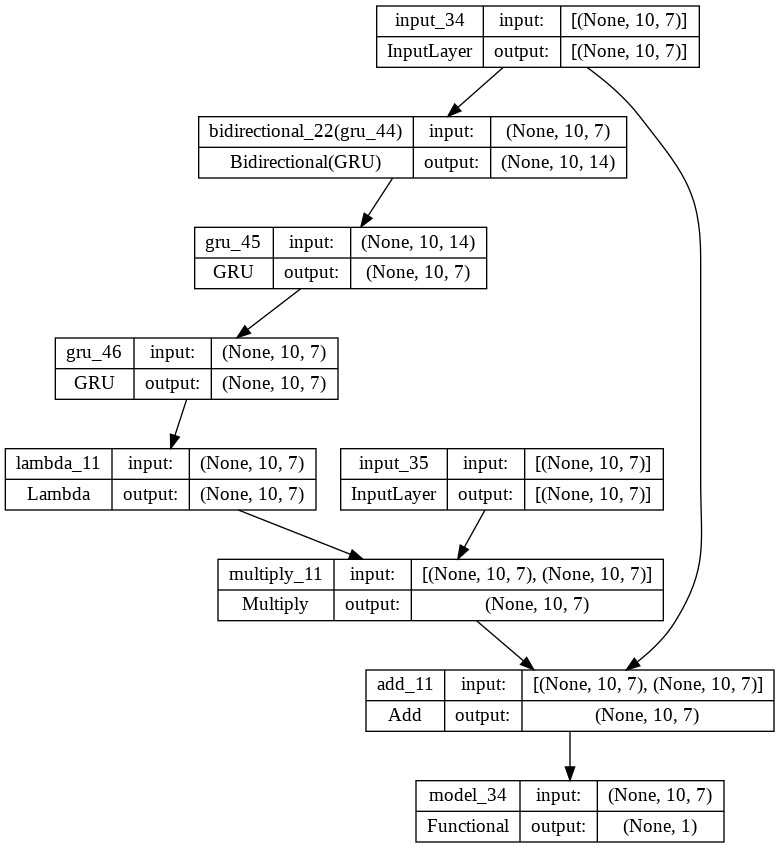

In [ ]:
# plot_model(generator, show_shapes=True)
# plot_model(discriminator, show_shapes=True) 
plot_model(GAN_model, show_shapes=True)

Training (mỗi lần chạy là 1 epoch)

In [ ]:
training(GAN_model, discriminator, generator, X_train_real, X_train, X_mask_train, epochs)

Epoch: 2: 100%|██████████| 180/180 [00:25<00:00,  7.00it/s]


Kiểm tra và đánh giá<br>
* Chỗ nào bị mất là do thực tế là số 0 nên bị replace mất á =)))

In [ ]:
i = 2 # batch thứ i (0, len(X_test)//batch_size) 
j = 0 # phần tử thứ j trong batch(0, batch_size - 1)
x_test = gen_z_input(batch_size, i, X_test, X_mask_test)
x_real = gen_z_input(batch_size, i, X_test_real, X_mask_test)
pred = generator.predict(x_test)

fill(i,j, x_test, x_real, pred, 0)

1/1 [==============================] - 0s 27ms/step
Errors (Normalized): 0.1956494298275858
------------------------------------------------------------------------------------
Boundery
      0      1      2       3       4     5       6
0  19.9  43.00   9.83    0.00   99.90  0.68   32.94
1  33.7  95.31  20.87  143.31  100.95  7.05  343.56
------------------------------------------------------------------------------------
Dữ liệu missing được điền khuyết
       0      1      2      3       4     5       6
0      -      -      -      -       -     -       -
1      -      -  13.87  58.06       -     -       -
2  25.94  63.79  14.63      -       -     -       -
3  26.66      -   15.0      -  100.41  3.75       -
4      -  63.72  14.99      -       -     -       -
5      -  64.52  14.66      -  100.46     -       -
6      -      -      -      -       -     -       -
7      -      -      -      -  100.49  4.24       -
8      -  67.03  14.38      -       -  4.13  193.64
9      -      -     

0.1956494298275858

In [ ]:
scores = []
for i in range(len(X_test)//batch_size):
  x_test = gen_z_input(batch_size, i, X_test, X_mask_test)
  x_real = gen_z_input(batch_size, i, X_test_real, X_mask_test)
  pred = generator.predict(x_test, verbose=0)
  for j in range(batch_size):
    scores.append(calc_error(pred[j], x_real[0][j], x_test[1][j]))

errors = np.mean(np.array(scores))
print('Errors:',errors)

Errors: 0.2800726073433352


# Điền khuyết truyền thống và GAN

Mean, median, mode<br>
['mean', 'median', 'most_frequent', 'constant']

In [ ]:
full_dset = np.array(data[["Temperature","Relative_Humidity","Specific_Humidity","Precipitation","Pressure","Wind_Speed","Wind_Direction"]])

In [ ]:
imputer_type = 'mean'

if(imputer_type != 'knn'):
  imputer = SimpleImputer(missing_values=np.nan, strategy=imputer_type)
  imputer = imputer.fit(missing_df)
else:
  imputer = KNNImputer()
  imputer = imputer.fit(missing_df)

normal_fill = imputer.transform(missing_df)

errors_normal = []
for i in range(len(missing_df)//timesteps):
  start = i*timesteps
  end = start + timesteps
  err = calc_error(normal_fill[start:end], full_dset[start:end], mask[start:end])
  errors_normal.append(err)
np.mean(np.array(errors_normal))

0.1426478177888486

GANImputer

In [ ]:
errors_gan = []
for i in range(len(missing_df)//timesteps):
  start = i*timesteps
  end = start + timesteps
  err = calc_error( generator.predict( [ missing[start:end].reshape(1,timesteps, features), mask[start:end].reshape(1,timesteps,features) ] , verbose = 0), 
                   full_dset[start:end], mask[start:end])
  errors_gan.append(err)
np.mean(np.array(errors_gan))

0.2752704928801805